# Explanations of machine learning models using CAM-based methods

In this tutorial you are going to examine how to use the CAM-based explanations to evaluate your ML model.

We begin by introducing the fundamental blocks used to perform an explanation on a single image:

This example corresponds to the one from the official tutorial and is used for demonstration purposes

In [1]:
!pip install grad-cam
!pip install medmnist

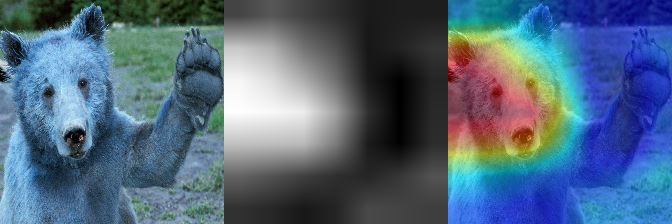

In [2]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image

model = models.resnet50(pretrained=True)
model.eval()
#image_url = "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0"
#img = np.array(Image.open(requests.get(image_url, stream=True).raw))
img = cv2.imread("C:\\Users\\m1choelz\\Downloads\\bear.jpg")
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

## Things to note down:

- You can change the model (any model from torchvision.models is typically fine)
- You can change the target layer (i.e. the layer which generates the predictions), but it recommended that you use the final convolutional layer
- If you do not specify the target class, then the explainer is going to select the most likely class (i.e. the class with the highest prediction confidence)

The confidence increase percent: -3.227439895272255
The visualization of the pertubated image for the metric:


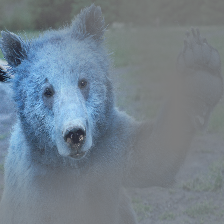

In [3]:
# Now lets see how to evaluate this explanation:
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget

# For the metrics we want to measure the change in the confidence, after softmax, that's why
# we use ClassifierOutputSoftmaxTarget.
targets = [ClassifierOutputSoftmaxTarget(295)]
cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {100*score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

## Benchmarking CAMs

You can use the existing benchmark method in your implementation if you wish, but it is here purely as an example of how to use different CAM attribution methods

In [4]:
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

print("Is CUDA available? ", cuda_available)

# If CUDA is available, you can also print the number of GPUs and their names
if cuda_available:
    print("Number of GPUs available: ", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print("GPU ", i, ": ", torch.cuda.get_device_name(i))

Is CUDA available?  True
Number of GPUs available:  1
GPU  0 :  NVIDIA RTX A3000 Laptop GPU


100%|██████████| 64/64 [00:03<00:00, 16.50it/s]


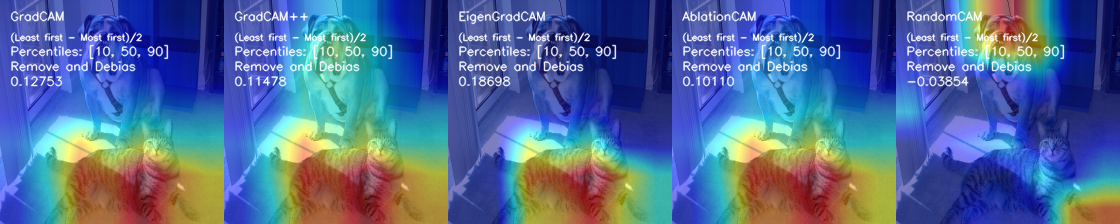

In [5]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM, LayerCAM, FullGrad, XGradCAM
from pytorch_grad_cam.metrics.road import ROADCombined

# Showing the metrics on top of the CAM :
def visualize_score(visualization, score, name, percentiles):
    visualization = cv2.putText(visualization, name, (10, 20),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 70),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 85),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    return visualization

def benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=281):
    methods = [("GradCAM", GradCAM(model=model, target_layers=target_layers)),
               ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers)),
               ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers)),
               ("AblationCAM", AblationCAM(model=model, target_layers=target_layers)),
               ("RandomCAM", RandomCAM(model=model, target_layers=target_layers)),
               
               ]

    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    targets = [ClassifierOutputTarget(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]

    visualizations = []
    percentiles = [10, 50, 90]
    for name, cam_method in methods:
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor,
                                      targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        score = scores[0]
        visualization = show_cam_on_image(cat_and_dog, attribution, use_rgb=True)
        visualization = visualize_score(visualization, score, name, percentiles)
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))

cat_and_dog_image_url = "C:\\Users\\m1choelz\\Downloads\\both.jpg"
cat_and_dog = cv2.imread(cat_and_dog_image_url)
cat_and_dog = np.float32(cat_and_dog) / 255
input_tensor = preprocess_image(cat_and_dog, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

model.cuda()
input_tensor = input_tensor.cuda()

# You can play around with the target classes, target layers and random seeds to see how the cams respond
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)

# target_layers = [model.layer4[-2]]
# benchmark(input_tensor, target_layers)
# benchmark(input_tensor, target_layers, category=246)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


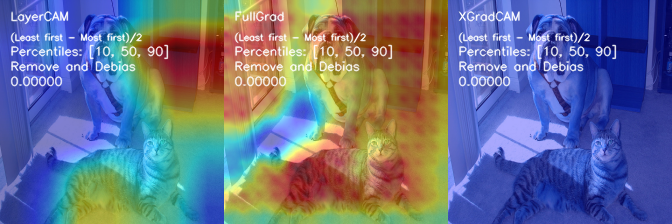

In [56]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM, LayerCAM, FullGrad, XGradCAM
from pytorch_grad_cam.metrics.road import ROADCombined

# Showing the metrics on top of the CAM :
def visualize_score(visualization, score, name, percentiles):
    visualization = cv2.putText(visualization, name, (10, 20),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 70),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 85),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    return visualization

def benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=281):
    methods = [
               ("LayerCAM", LayerCAM(model=model, target_layers=target_layers)),
               ("FullGrad", FullGrad(model=model, target_layers=target_layers)),
               ("XGradCAM", XGradCAM(model=model, target_layers=target_layers))
               ]

    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    targets = [ClassifierOutputTarget(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]

    visualizations = []
    percentiles = [10, 50, 90]
    for name, cam_method in methods:
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor,
                                      targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        score = scores[0]
        print(cat_and_dog.shape)
        visualization = show_cam_on_image(cat_and_dog, attribution, use_rgb=True)
        visualization = visualize_score(visualization, score, name, percentiles)
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))

cat_and_dog_image_url = "C:\\Users\\m1choelz\\Downloads\\both.jpg"
cat_and_dog = cv2.imread(cat_and_dog_image_url)
cat_and_dog = np.float32(cat_and_dog) / 255
input_tensor = preprocess_image(cat_and_dog, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

model.cuda()
input_tensor = input_tensor.cuda()

# You can play around with the target classes, target layers and random seeds to see how the cams respond
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)

# target_layers = [model.layer4[-2]]
# benchmark(input_tensor, target_layers)
# benchmark(input_tensor, target_layers, category=246)

## This section shows you how to load the MedMNIST dataset

In [297]:
import medmnist
from medmnist import INFO, Evaluator
from torchvision import transforms
from torchvision.transforms import ToTensor, Lambda
import torch.utils.data as data

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data; you are free to choose the dataset yourself, but beware that not all of
# them are compatible with the standard torchvision models
data_flag ='bloodmnist' #'breastmnist'#'bloodmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

train_set = DataClass(split='train', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
test_set = DataClass(split='test', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
val_set = DataClass(split='val', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
# You are expected to create the appropriate dataloaders to be used for training, testing and validation
# We propose a 70-15-15 split, but this is entirely up to you

### YOUR CODE BELOW ###
#model = models.resnet50(pretrained=True)
train_loader = data.DataLoader(dataset=train_set, batch_size=64, shuffle=True)
test_loader = data.DataLoader(dataset=test_set, batch_size=64, shuffle=False)
valid_loader = data.DataLoader(dataset=val_set, batch_size=64, shuffle=False)


Using downloaded and verified file: C:\Users\m1choelz\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\m1choelz\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\m1choelz\.medmnist\bloodmnist.npz


In [271]:
print(test_set)

Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 3421
    Root location: C:\Users\m1choelz\.medmnist
    Split: test
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC BY

In [70]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer6 = nn.Sequential(
            nn.Linear(32 * 3 * 3, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
            nn.Sigmoid())


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(-1, 32*3*3)
        x = self.layer6(x)
        return x

# initialize your model


# define the BCE loss function and an optimizer you prefer
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=3e-03)

In [298]:
model = models.resnet50(pretrained=True)
# binary model: 
#model = CNN(in_channels=1, num_classes=2)

### Model training

Now that you have loaded the model and the dataset, you can proceed to training it
We provide you with a sample training loop, you are allowed to modify it as you please

Your goal here is to add the explanations to either the validation or the testing loop
It is entirely up to you how to achieve this; the main goal of the exercise is to observe how
the explanations change over the course of training.

Hint: you may want to run the explainer on the untrained model to get a baseline 'random' prediction

In [273]:
import matplotlib.pyplot as plt

In [309]:
import cv2

def continuous_explanation( model, loader, device, epoch, mode):
    model.eval()  # Set model to evaluation mode for explanation
    target_layers = [model.layer4]
    
    for batch, (data, target) in enumerate(loader):
        visualizations = []

        if batch > 0 and mode != 'test': break  # Limit to one batch for demonstration
        data = data.to(device)
        pred = model(data)
        predicted_class = pred.argmax(dim=1)[0].item()
        actual_class = target[0].item()

        # Process a single image for CAM
        input_tensor = data[0:1]  # Keep the batch dimension as 1
        targets = [ClassifierOutputTarget(predicted_class)]

        methods = [("GradCAM", GradCAM(model=model, target_layers = target_layers)),
                ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers)),
                ("LayerCAM", LayerCAM(model=model, target_layers=target_layers)),
            #    ("FullGrad", FullGrad(model=model, target_layers=target_layers)),
            #    ("XGradCAM", XGradCAM(model=model, target_layers=target_layers))
               ]

        # Generate CAM for the specified methods
        for name, cam_method in methods:

            cam_image = generate_cam(cam_method, input_tensor, targets)
            # visualization = add_text_to_image(cam_image, name)
            visualizations.append((name, cam_image))

        # Display the original image and CAM visualizations
        display_images(data, visualizations, epoch, batch, predicted_class, actual_class, mode)
        plt.pause(0.005)  # Pause to update plots
    model.train()  # Set model back to training mode

def generate_cam(cam_method, input_tensor, targets):
    with cam_method:
        attributions = cam_method(input_tensor=input_tensor, targets=targets,eigen_smooth=False, aug_smooth=False)
        grayscale_cam = attributions[0, :]
        img = input_tensor[0].cpu().numpy().transpose(1, 2, 0)
        img = (img - img.min()) / (img.max() - img.min())  # Normalize
        cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
        return cam_image

def add_text_to_image(image, text):
    return cv2.putText(image, text, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, cv2.LINE_AA)

def display_images(data, visualizations, epoch, batch, predicted_class, actual_class, mode):
    plt.figure(figsize=(15, 10))
    plt.subplot(1, len(visualizations) + 1, 1)

    if data.shape[1] == 3: 
        plt.imshow(data[0].cpu().numpy().transpose(1, 2, 0))
    else: 
        plt.imshow(data[0].cpu().squeeze(), cmap='gray')
    plt.title('Original Image')
    for i, (name,visualization) in enumerate(visualizations):
        plt.subplot(1, len(visualizations) + 1, i+2)
        plt.imshow(visualization)
        if mode == 'test': 
            plt.title(f'{name}\n Batch {batch+1}\nPredicted: {predicted_class}, Actual: {actual_class}')
        else: 
            plt.title(f'{name}\nEpoch {epoch+1}, Batch {batch+1}\nPredicted: {predicted_class}, Actual: {actual_class}')
    plt.show()


In [287]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


# You are expected to save the models during training
# It is up to you to decide when and how to do so, but this is likely to influence the explanation results

### YOUR CODE BELOW ###
saved_models = None

def train(device, model, train_loader, epochs, learning_rate):
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.NAdam(model.parameters(), lr=learning_rate)
    best_val_loss = float('inf') 
    

    for epoch in range(epochs):
        losses = []
        valid_losses = []
        accuracies = []
        model.train()
        for i, (data, target) in enumerate(tqdm(train_loader, desc='Training-loop')):
            optimizer.zero_grad()
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target.long())

            preds = torch.argmax(output.detach().cpu(), axis=1)
            labels = target.detach().cpu()
            acc = np.mean(preds.numpy() == labels.numpy())
            losses.append(loss.item())
            accuracies.append(acc)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 20 == 0:  # Explanation every 10 batches
                continuous_explanation(model, valid_loader, device, epoch, 'val')

        # Validation step 
        model.eval()
        with torch.no_grad():
            for idx, (data, target) in enumerate(tqdm(valid_loader, desc='Validation-loop')):
                image, target = data.to(device), target.to(device)
                pred = model(image)
                loss = criterion(pred, target.long())
                valid_losses.append(loss.item())
                # does work yet: 
                # continuous_explanation(model, valid_loader, device, epoch, 'val')
        # Model saving based on vlaidation loss: 
        avg_val_loss = np.mean(valid_losses)
        if avg_val_loss < best_val_loss: 
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')


        # We suggest you modify this code to run the continuous explanations
        # print(f"Grad-cam testing")
        # target_layers = [model.layer4]
        
        print(
            f"Train Epoch: {epoch + 1} "
            f"Loss: {np.mean(losses):.6f} "
            f"Validation loss: {np.mean(valid_losses):.6f} "
            f"Acc: {np.mean(accuracies) * 100:.6f} "
        )
    return model

In [237]:
import matplotlib.pyplot as plt

def test(model, device, data_loader, mean=0.5432, std=0.2731):
    model.eval()
    preds = []
    pred_list = []
    correct = 0

    with torch.no_grad():
        for index, (image, target) in enumerate(tqdm(data_loader, desc='Test-loop')):
            images = image.to(device)
            target = target

            output = model(images).detach().cpu()
            preds = np.argmax(output, axis=1).numpy()
            labels = target.numpy()

            correct += (preds == labels).sum()

            pred_list.append(preds)

    acc = correct / len(test_loader.dataset) * 100
    print(f"Test Accuracy: {acc:.6f}")

    # You should modify this section to reflect your CAM evaluation
    print(f"Grad-cam testing")
    target_layers = [model.layer4]  # Replace with your model's specific layer
    cam = GradCAM(model=model, target_layers=target_layers)

    #target_layers = None
    #with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
        #pass
    continuous_explanation( model, data_loader, device, 0, 'test')



    return np.concatenate(pred_list)

In [ ]:

def continuous_explanation(cam, model, loader, device):
    model.eval()  # Set model to evaluation mode for explanation
    for batch, (data, _) in enumerate(loader):
        if batch > 0: break  # Limit to one batch for demonstration
        data = data.to(device)
        cam.batch_size = data.size(0)
        grayscale_cams = cam(input_tensor=data)
        # Convert the first image to RGB
        img = data[0].cpu().numpy().transpose(1, 2, 0)
        img = (img - img.min()) / (img.max() - img.min())
        cam_image = show_cam_on_image(img, grayscale_cams[0, :])
        plt.imshow(cam_image)
        plt.title(f'Grad-CAM Epoch {epoch+1}, Batch {batch+1}')
        plt.pause(0.001)  # Pause to update plots
    model.train()  # Set model back to training mode

Training-loop:   0%|          | 0/187 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([4, 0, 7, 6, 1, 6, 1, 7, 6, 5, 2, 1, 6, 2, 7, 6, 4, 4, 5, 7, 6, 2, 5, 1,
        7, 3, 6, 6, 6, 1, 7, 0, 0, 5, 2, 7, 2, 0, 0, 6, 7, 6, 6, 6, 6, 3, 5, 4,
        1, 3, 7, 1, 1, 5, 7, 4, 4, 1, 6, 3, 0, 6, 1, 1], dtype=torch.int32)


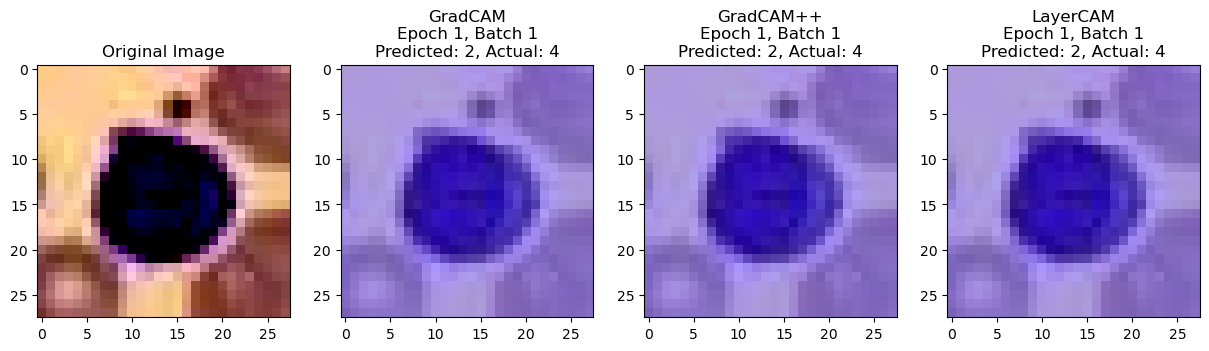

Training-loop:  10%|█         | 19/187 [00:02<00:13, 12.63it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([4, 0, 7, 6, 1, 6, 1, 7, 6, 5, 2, 1, 6, 2, 7, 6, 4, 4, 5, 7, 6, 2, 5, 1,
        7, 3, 6, 6, 6, 1, 7, 0, 0, 5, 2, 7, 2, 0, 0, 6, 7, 6, 6, 6, 6, 3, 5, 4,
        1, 3, 7, 1, 1, 5, 7, 4, 4, 1, 6, 3, 0, 6, 1, 1], dtype=torch.int32)


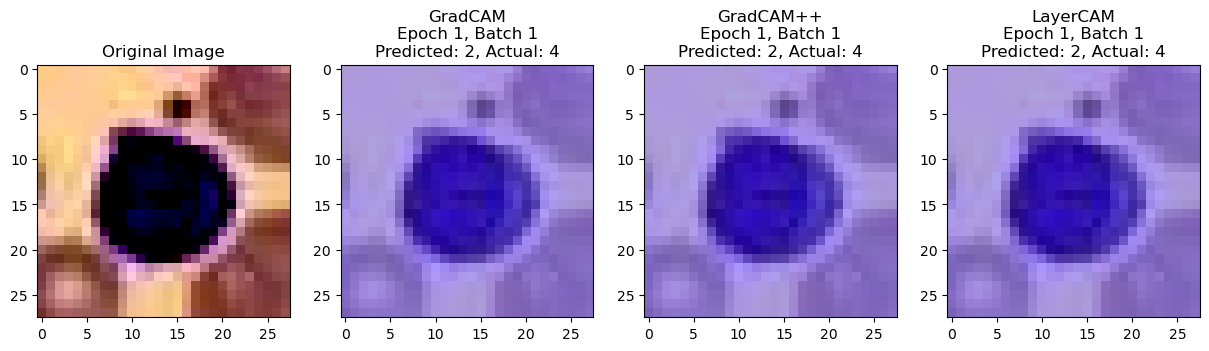

Training-loop:  11%|█         | 21/187 [00:03<00:23,  6.95it/s]


KeyboardInterrupt: 

In [308]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = train(device, model, train_loader, 10, 3e-03)

Test-loop: 100%|██████████| 3/3 [00:00<00:00, 96.52it/s]


Test Accuracy: 85.256410
Grad-cam testing


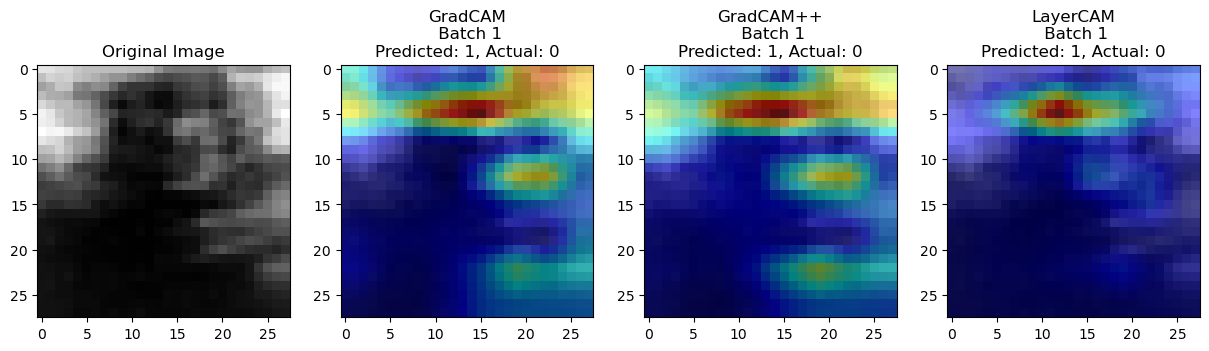

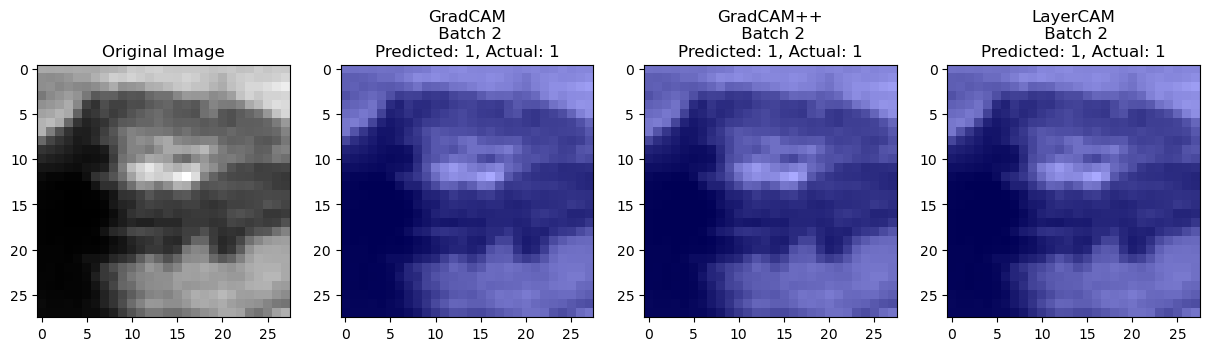

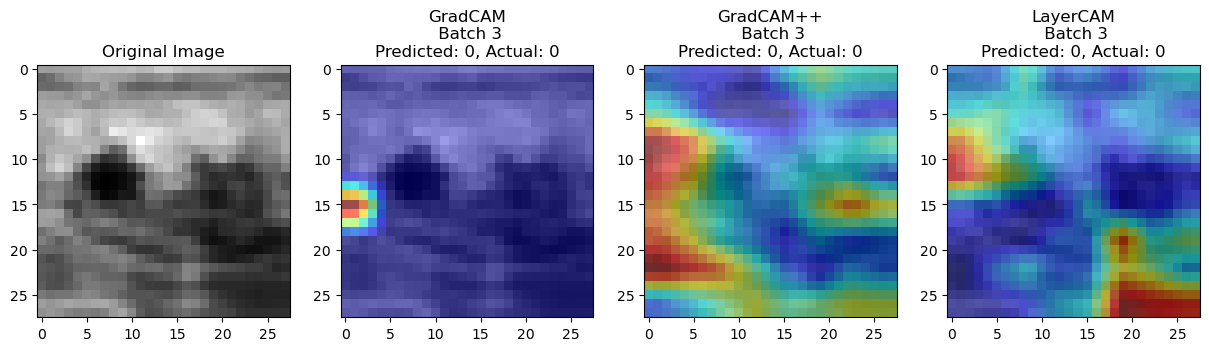

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1], dtype=int64)

In [269]:
test(model, device, test_loader)